# MLOps Lab 2 Assignment (MLFlow) For Lab 5

Author: Grant Nitta

Date Created: 04/15/2025

Date Last Modified: 04/15/2025

# Task

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

# Library Importation

In [1]:
import mlflow
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Data Importation

In [2]:
# pip install ucimlrepo
# !pip install statsmodels

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
# student_performance = fetch_ucirepo(id=320)

# # data (as pandas dataframes)
# X = student_performance.data.features
# y = student_performance.data.targets

# metadata
# print(student_performance.metadata)

# # variable information
# print(student_performance.variables)

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

# metadata
# print(iris.metadata)

# # variable information
# print(iris.variables)

# EDA

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


array([[<Axes: title={'center': 'sepal length'}>,
        <Axes: title={'center': 'sepal width'}>],
       [<Axes: title={'center': 'petal length'}>,
        <Axes: title={'center': 'petal width'}>]], dtype=object)

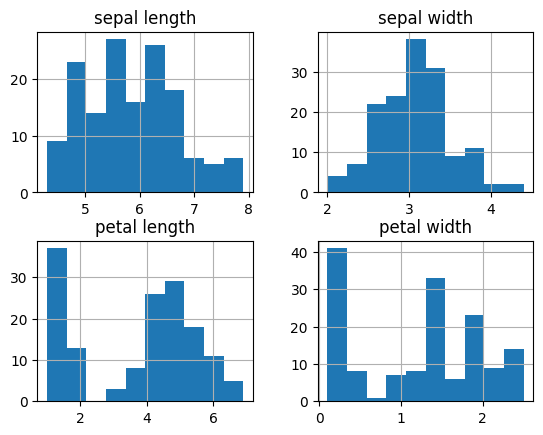

In [5]:
X.hist()

<Axes: >

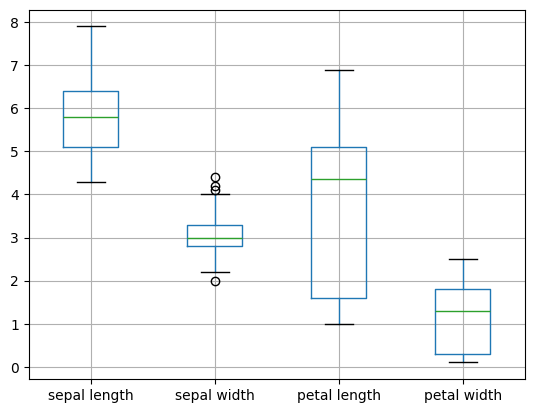

In [6]:
X.boxplot()

In [7]:
X.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   150 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


# Setting up MLFlow

In [9]:
mlflow.set_tracking_uri("https://lab5service-993985116211.us-west2.run.app")
mlflow.set_experiment("Lab5-student_performance_Iris")

2025/04/15 01:09:33 INFO mlflow.tracking.fluent: Experiment with name 'Lab5-student_performance_Iris' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1744704574199, experiment_id='1', last_update_time=1744704574199, lifecycle_stage='active', name='Lab5-student_performance_Iris', tags={}>

# Experimenting Phase 1

In [10]:
X_encoded = X.copy()

# Track column transformations
column_mapping = {}
label_encoders = {}

# Find all object and category columns
string_columns = X.select_dtypes(include=["object", "category"]).columns

for col in string_columns:
    # For columns with many unique values, use label encoding
    le = LabelEncoder()
    X_encoded[col + "_encoded"] = le.fit_transform(X[col])

    # Drop the original column
    X_encoded = X_encoded.drop(col, axis=1)

    # Store mapping information
    column_mapping[col] = [col + "_encoded"]
    label_encoders[col] = le

X_encoded = X_encoded.astype(float)
# y_use = y["G1"]
y_use = y.values.ravel()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_use, test_size=0.2, shuffle=True
)
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True
)

# Initial Training

In [12]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params["type"]
        del params["type"]
        if classifier_type == "dt":
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == "rf":
            clf = RandomForestClassifier(**params)
        elif classifier_type == "gb":
            clf = GradientBoostingClassifier(**params)
        else:
            return 0
        acc = cross_val_score(clf, X_train_val, y_train_val).mean()

        mlflow.set_tag("Model", classifier_type)

        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {"loss": -acc, "status": STATUS_OK}


search_space = hp.choice(
    "classifier_type",
    [
        {
            "type": "dt",
            "criterion": hp.choice("dtree_criterion", ["gini", "entropy"]),
            "max_depth": hp.choice(
                "dtree_max_depth",
                [None, hp.randint("dtree_max_depth_int", 1, 10)],
            ),
            "min_samples_split": hp.randint("dtree_min_samples_split", 2, 10),
        },
        {
            "type": "rf",
            "n_estimators": hp.randint("rf_n_estimators", 20, 500),
            "max_features": hp.randint("rf_max_features", 2, 9),
            "criterion": hp.choice("criterion", ["gini", "entropy"]),
        },
        {
            "type": "gb",
            "loss": hp.choice("gb_loss", ["log_loss"]),
            "learning_rate": hp.uniform("gb_learning_rate", 0.05, 2),
            "n_estimators": hp.randint("gb_n_estimators", 20, 500),
            "subsample": hp.uniform("gb_subsample", 0.1, 1),
            "criterion": hp.choice(
                "gb_criterion", ["friedman_mse", "squared_error"]
            ),
            "max_depth": hp.choice(
                "gb_max_depth",
                [None, hp.randint("gb_max_depth_int", 1, 10)],
            ),
        },
    ],
)

algo = tpe.suggest
trials = Trials()

In [13]:
best_result = fmin(
    fn=objective, space=search_space, algo=algo, max_evals=32, trials=trials
)
best_result

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/15 01:09:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run charming-ape-319 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/5c21e29f6b9c47478b1225a1c7925272.

2025/04/15 01:09:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



  3%|▎         | 1/32 [00:01<00:35,  1.15s/trial, best loss: -0.9473684210526315]

2025/04/15 01:09:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-lamb-381 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/1433cd3018e049229ea5e6fbb9e6ddf6.

2025/04/15 01:09:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



  6%|▋         | 2/32 [00:02<00:35,  1.18s/trial, best loss: -0.9473684210526315]

2025/04/15 01:09:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-loon-972 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/fe64ce885f004431973f9801d3686069.

2025/04/15 01:09:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



  9%|▉         | 3/32 [00:03<00:30,  1.05s/trial, best loss: -0.9473684210526315]

2025/04/15 01:09:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-seal-992 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/66c8b79e982946b1a209e9d932bfb658.

2025/04/15 01:09:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 12%|█▎        | 4/32 [00:04<00:26,  1.06trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-hare-5 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/fcbc89eb36f049d8b5564c6eb1c5057f.

2025/04/15 01:09:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 16%|█▌        | 5/32 [00:04<00:25,  1.05trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-jay-159 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/a9a000dee40140e8bbd8ee2a6c93030c.

2025/04/15 01:09:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 19%|█▉        | 6/32 [00:05<00:21,  1.19trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-bass-531 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/6d2e795de0444f12a6a7bcd97a8d5329.

2025/04/15 01:09:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 22%|██▏       | 7/32 [00:06<00:19,  1.31trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-swan-593 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b389d5dc47444cadbef677f864c6e0f4.

2025/04/15 01:09:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 25%|██▌       | 8/32 [00:07<00:20,  1.18trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-sow-947 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/c69119cabafc44de991ee38a5a97463a.

2025/04/15 01:09:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 28%|██▊       | 9/32 [00:08<00:22,  1.04trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-snail-165 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/fc75f8d7dbad46208d5aacd2eb24f66f.

2025/04/15 01:09:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 31%|███▏      | 10/32 [00:09<00:21,  1.01trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-colt-576 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/57ff2436e74d4762b3563840fff75b5d.

2025/04/15 01:09:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 34%|███▍      | 11/32 [00:09<00:17,  1.23trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-crow-222 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/0a7584c906434be5840f1b457df5c103.

2025/04/15 01:09:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 38%|███▊      | 12/32 [00:10<00:16,  1.18trial/s, best loss: -0.9473684210526315]

2025/04/15 01:09:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-finch-344 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/97c2a2faa042408193a27a5ee3a61715.

2025/04/15 01:09:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 41%|████      | 13/32 [00:11<00:15,  1.21trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-pug-223 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/46284efa65244691afe075ccb8f9b2e8.

2025/04/15 01:09:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 44%|████▍     | 14/32 [00:12<00:15,  1.15trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-yak-585 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/2b7632555c7c4fd8b21c433cf1c4332d.

2025/04/15 01:09:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 47%|████▋     | 15/32 [00:13<00:15,  1.12trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run magnificent-fox-774 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/a48f524c7676442ebedeb9fa9df0b504.

2025/04/15 01:09:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 50%|█████     | 16/32 [00:13<00:11,  1.38trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-jay-131 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/54ca076225f9457c867afa8e1227d99c.

2025/04/15 01:09:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 53%|█████▎    | 17/32 [00:14<00:09,  1.65trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-koi-177 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/14f2e5f76ff74542ad77a89a0651c935.

2025/04/15 01:09:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 56%|█████▋    | 18/32 [00:15<00:09,  1.44trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-perch-503 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/16a637b1693240299e204cbddd0c4090.

2025/04/15 01:09:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 59%|█████▉    | 19/32 [00:16<00:09,  1.33trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-bird-961 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b7499ab28b3640859af34fa5782aad93.

2025/04/15 01:09:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 62%|██████▎   | 20/32 [00:16<00:07,  1.58trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run bustling-goose-728 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/31474122ba5241c08b1aa9b744799b64.

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 66%|██████▌   | 21/32 [00:16<00:05,  1.85trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-koi-346 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/53b630947c454c5b989d9d7cef1c04a2.

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 69%|██████▉   | 22/32 [00:17<00:04,  2.08trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-toad-315 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/d50ac38ea9ff40ebb10b7ca1cbbaf835.

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 72%|███████▏  | 23/32 [00:17<00:03,  2.36trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-cub-281 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/ebe7e15ca73048d7b0e25b1d5c36f8b4.

2025/04/15 01:09:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 75%|███████▌  | 24/32 [00:17<00:03,  2.62trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-gnu-18 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/a866f2e8c4d4487c96e8f41d2e75ae5c.

2025/04/15 01:09:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 78%|███████▊  | 25/32 [00:17<00:02,  2.81trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-ant-522 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/c2f3bef4847d42da9eae2d2a130867b5.

2025/04/15 01:09:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 81%|████████▏ | 26/32 [00:18<00:02,  2.68trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-bird-592 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/6a85815a8ed844a2a0f0822143e2a1cb.

2025/04/15 01:09:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 84%|████████▍ | 27/32 [00:19<00:02,  1.93trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-sponge-20 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/0baec16861eb44358596f3611c5e22d7.

2025/04/15 01:09:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 88%|████████▊ | 28/32 [00:20<00:02,  1.53trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-newt-651 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/4762d31142824f6283c292b9e9ad0890.

2025/04/15 01:09:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 91%|█████████ | 29/32 [00:20<00:02,  1.48trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-snipe-491 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/644d908123204263b90d2131b6ad02b3.

2025/04/15 01:09:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 94%|█████████▍| 30/32 [00:21<00:01,  1.46trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-hawk-820 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/d60343618a814adda12d4f84e12d8306.

2025/04/15 01:09:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 97%|█████████▋| 31/32 [00:22<00:00,  1.39trial/s, best loss: -0.9578947368421051]

2025/04/15 01:09:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-wolf-694 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/4538ae61b7e24327859c49a4387ae0e4.

2025/04/15 01:09:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



100%|██████████| 32/32 [00:23<00:00,  1.38trial/s, best loss: -0.9578947368421051]


{'classifier_type': 1,
 'criterion': 0,
 'rf_max_features': 8,
 'rf_n_estimators': 251}

# Feature Selection

In [14]:
X_redcued_train = X_train.copy()
VIF = [0]
while len(VIF) > 0:
    X_numeric = pd.DataFrame()
    for col in X_redcued_train.columns:
        # Force everything through string conversion to be safe
        X_numeric[col] = pd.to_numeric(
            X_train[col].astype(str), errors="coerce"
        )

    # Now calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_numeric.values, i)
        for i in range(X_numeric.shape[1])
    ]
    vif_test = vif_data.set_index("Feature").sort_values(
        by="VIF", ascending=False
    )
    if vif_test.max().iloc[0] > 5:
        print(VIF)
        VIF = vif_test.idxmax().iloc[0]
        X_redcued_train.drop(VIF, axis=1, inplace=True)
    else:
        print("Stopping")
        VIF = []

[0]
sepal length
Stopping


In [15]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params["type"]
        del params["type"]
        if classifier_type == "dt":
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == "rf":
            clf = RandomForestClassifier(**params)
        elif classifier_type == "gb":
            clf = GradientBoostingClassifier(**params)
        else:
            return 0
        acc = cross_val_score(clf, X_redcued_train, y_train).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.set_tag("Data", "Training")
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path="better_models")
        mlflow.end_run()
        return {"loss": -acc, "status": STATUS_OK}


search_space = hp.choice(
    "classifier_type",
    [
        {
            "type": "dt",
            "criterion": hp.choice("dtree_criterion", ["gini", "entropy"]),
            "max_depth": hp.choice(
                "dtree_max_depth",
                [None, hp.randint("dtree_max_depth_int", 1, 10)],
            ),
            "min_samples_split": hp.randint("dtree_min_samples_split", 2, 10),
        },
        {
            "type": "rf",
            "n_estimators": hp.randint("rf_n_estimators", 20, 500),
            "max_features": hp.randint("rf_max_features", 2, 9),
            "criterion": hp.choice("criterion", ["gini", "entropy"]),
        },
        {
            "type": "gb",
            "loss": hp.choice("gb_loss", ["log_loss"]),
            "learning_rate": hp.uniform("gb_learning_rate", 0.05, 2),
            "n_estimators": hp.randint("gb_n_estimators", 20, 500),
            "subsample": hp.uniform("gb_subsample", 0.1, 1),
            "criterion": hp.choice(
                "gb_criterion", ["friedman_mse", "squared_error"]
            ),
            "max_depth": hp.choice(
                "gb_max_depth",
                [None, hp.randint("gb_max_depth_int", 1, 10)],
            ),
        },
    ],
)

algo = tpe.suggest
trials = Trials()

In [16]:
best_result = fmin(
    fn=objective, space=search_space, algo=algo, max_evals=32, trials=trials
)
best_result

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/15 01:10:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-hog-685 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/4ce1962abaed409bbd125f9f4870903c.

2025/04/15 01:10:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



  3%|▎         | 1/32 [00:04<02:21,  4.56s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-rat-912 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b5e71ed4eb074f8c8494cfe459e99ba8.

2025/04/15 01:10:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



  6%|▋         | 2/32 [00:08<01:57,  3.92s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-lamb-84 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b99e82d938d444469a8d0b4a0f694648.

2025/04/15 01:10:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



  9%|▉         | 3/32 [00:11<01:43,  3.58s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-steed-544 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b592905283244eda8f82f555ef1daa54.

2025/04/15 01:10:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 12%|█▎        | 4/32 [00:14<01:39,  3.54s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-stoat-837 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/85ca73997b7d4010956aab87e9d17cda.

2025/04/15 01:10:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 16%|█▌        | 5/32 [00:18<01:36,  3.56s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-eel-382 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/7b8a8e8444e947778c6360b0a180fc8b.

2025/04/15 01:10:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 19%|█▉        | 6/32 [00:21<01:28,  3.39s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-doe-882 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/760c6f830a1c4ea885a32feefeea3d69.

2025/04/15 01:10:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 22%|██▏       | 7/32 [00:25<01:28,  3.55s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-fowl-208 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/ef6b52de4fa6476eaf76c8294c595bea.

2025/04/15 01:10:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 25%|██▌       | 8/32 [00:29<01:29,  3.73s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-turtle-585 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/5ae9322b91cc41ba9eca227ecb27a985.

2025/04/15 01:10:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 28%|██▊       | 9/32 [00:32<01:20,  3.51s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-slug-50 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/98466e7658f84985a17827991345ed4a.

2025/04/15 01:10:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 31%|███▏      | 10/32 [00:36<01:18,  3.55s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-seal-432 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/98b720acfea64c4ca824bdb6e3f03ab0.

2025/04/15 01:10:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 34%|███▍      | 11/32 [00:40<01:18,  3.74s/trial, best loss: -0.9416666666666668]

2025/04/15 01:10:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-swan-810 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/c8595298551b436e936fe8668cbcb300.

2025/04/15 01:10:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 38%|███▊      | 12/32 [00:43<01:13,  3.66s/trial, best loss: -0.95]              

2025/04/15 01:10:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-slug-62 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/0cf096f3ffb34210931ad13dbd38a684.

2025/04/15 01:10:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 41%|████      | 13/32 [00:46<01:07,  3.53s/trial, best loss: -0.95]

2025/04/15 01:10:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-skink-389 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/95900fbf0c294c4d9f08746fe5465132.

2025/04/15 01:10:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 44%|████▍     | 14/32 [00:50<01:03,  3.54s/trial, best loss: -0.95]

2025/04/15 01:10:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-sponge-745 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/a46f9b51076e4ecfa522bdba36aed243.

2025/04/15 01:10:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 47%|████▋     | 15/32 [00:54<01:01,  3.62s/trial, best loss: -0.95]

2025/04/15 01:10:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-cow-879 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/7f68d3f45cc740e5876a46661f6a5ec7.

2025/04/15 01:10:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 50%|█████     | 16/32 [00:57<00:58,  3.64s/trial, best loss: -0.95]

2025/04/15 01:10:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:10:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-flea-46 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b137f4e862aa46448f661959677c7009.

2025/04/15 01:10:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 53%|█████▎    | 17/32 [01:01<00:52,  3.50s/trial, best loss: -0.95]

2025/04/15 01:11:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-sponge-821 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b037d8d7ec3145809cac8ce3ea1105f9.

2025/04/15 01:11:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 56%|█████▋    | 18/32 [01:04<00:48,  3.49s/trial, best loss: -0.95]

2025/04/15 01:11:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-gnat-591 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/04837034a031483e87b23de8fff74ba9.

2025/04/15 01:11:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 59%|█████▉    | 19/32 [01:08<00:45,  3.48s/trial, best loss: -0.95]

2025/04/15 01:11:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-fox-369 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/80be755d199643e093f64522027d5450.

2025/04/15 01:11:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 62%|██████▎   | 20/32 [01:12<00:46,  3.89s/trial, best loss: -0.95]

2025/04/15 01:11:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-vole-738 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/2eb41509da64402e9f7c7e2301f40bbf.

2025/04/15 01:11:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 66%|██████▌   | 21/32 [01:15<00:39,  3.59s/trial, best loss: -0.95]

2025/04/15 01:11:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-asp-864 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/cff0a10e82594009a35700366de272b8.

2025/04/15 01:11:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 69%|██████▉   | 22/32 [01:18<00:33,  3.39s/trial, best loss: -0.95]

2025/04/15 01:11:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run unique-shad-561 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/e39a7ca8207d4e6ca381432b9ba3d50a.

2025/04/15 01:11:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 72%|███████▏  | 23/32 [01:21<00:28,  3.21s/trial, best loss: -0.95]

2025/04/15 01:11:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-kit-477 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/b6e967e919b2486b9abd58232bb37c62.

2025/04/15 01:11:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 75%|███████▌  | 24/32 [01:24<00:24,  3.10s/trial, best loss: -0.95]

2025/04/15 01:11:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-hawk-533 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/837d338a79cf4adc8130c79631409bc8.

2025/04/15 01:11:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 78%|███████▊  | 25/32 [01:27<00:21,  3.11s/trial, best loss: -0.95]

2025/04/15 01:11:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-deer-588 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/8e2d884e32614f6eb3944ce797484b7a.

2025/04/15 01:11:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 81%|████████▏ | 26/32 [01:30<00:18,  3.14s/trial, best loss: -0.95]

2025/04/15 01:11:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-newt-62 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/39dde5dcaf1c4d3db73691a6e03c0e01.

2025/04/15 01:11:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 84%|████████▍ | 27/32 [01:33<00:15,  3.12s/trial, best loss: -0.95]

2025/04/15 01:11:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-fowl-947 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/362e8e2a65034f9b97491851ef18c87e.

2025/04/15 01:11:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 88%|████████▊ | 28/32 [01:36<00:12,  3.08s/trial, best loss: -0.95]

2025/04/15 01:11:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-perch-747 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/2310455ac40d4ab7ba6588fb1a28f435.

2025/04/15 01:11:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 91%|█████████ | 29/32 [01:39<00:09,  3.09s/trial, best loss: -0.95]

2025/04/15 01:11:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-mare-46 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/8bab75bdac6c475495fa64805ecb2c63.

2025/04/15 01:11:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 94%|█████████▍| 30/32 [01:42<00:06,  3.04s/trial, best loss: -0.95]

2025/04/15 01:11:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-rat-252 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/f24591d79e6f4248b2a6eca276f367c6.

2025/04/15 01:11:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



 97%|█████████▋| 31/32 [01:45<00:03,  3.05s/trial, best loss: -0.95]

2025/04/15 01:11:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/15 01:11:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-pug-673 at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1/runs/49f72f7b944f4bb2a252c1a7c2e87994.

2025/04/15 01:11:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://lab5service-993985116211.us-west2.run.app/#/experiments/1.



100%|██████████| 32/32 [01:48<00:00,  3.40s/trial, best loss: -0.95]


{'classifier_type': 0,
 'dtree_criterion': 1,
 'dtree_max_depth': 1,
 'dtree_max_depth_int': 3,
 'dtree_min_samples_split': 6}

# Top 3 Best Training Models

1. 4538ae61b7e24327859c49a4387ae0e4
2. 6a85815a8ed844a2a0f0822143e2a1cb
3. 97c2a2faa042408193a27a5ee3a61715

# Using Validation Set to find the Best

In [19]:
X_redcued_val = X_val.copy()
VIF = [0]
while len(VIF) > 0:
    X_numeric = pd.DataFrame()
    for col in X_redcued_val.columns:
        # Force everything through string conversion to be safe
        X_numeric[col] = pd.to_numeric(
            X_train[col].astype(str), errors="coerce"
        )

    # Now calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_numeric.values, i)
        for i in range(X_numeric.shape[1])
    ]
    vif_test = vif_data.set_index("Feature").sort_values(
        by="VIF", ascending=False
    )
    if vif_test.max().iloc[0] > 5:
        print(VIF)
        VIF = vif_test.idxmax().iloc[0]
        X_redcued_val.drop(VIF, axis=1, inplace=True)
    else:
        print("Stopping")
        VIF = []

[0]
sepal length
Stopping


In [20]:
top3_1_logged_model = "runs:/4538ae61b7e24327859c49a4387ae0e4/better_models"  # replace with one of your models

# Load model as a PyFuncModel.
top3_1_loaded_model = mlflow.pyfunc.load_model(top3_1_logged_model)

top3_2_logged_model = "runs:/6a85815a8ed844a2a0f0822143e2a1cb/better_models"  # replace with one of your models

# Load model as a PyFuncModel.
top3_2_loaded_model = mlflow.pyfunc.load_model(top3_2_logged_model)

top3_3_logged_model = "runs:/97c2a2faa042408193a27a5ee3a61715/better_models"  # replace with one of your models

# Load model as a PyFuncModel.
top3_3_loaded_model = mlflow.pyfunc.load_model(top3_3_logged_model)

model_1_train = mlflow.sklearn.load_model(top3_1_logged_model)
model_2_train = mlflow.sklearn.load_model(top3_2_logged_model)
model_3_train = mlflow.sklearn.load_model(top3_3_logged_model)

/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MlflowException: The following failures occurred while downloading one or more artifacts from https://lab5service-993985116211.us-west2.run.app/api/2.0/mlflow-artifacts/artifacts/1/4538ae61b7e24327859c49a4387ae0e4/artifacts:
##### File better_models #####
API request to https://lab5service-993985116211.us-west2.run.app/api/2.0/mlflow-artifacts/artifacts/1/4538ae61b7e24327859c49a4387ae0e4/artifacts/better_models failed with exception HTTPSConnectionPool(host='lab5service-993985116211.us-west2.run.app', port=443): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/1/4538ae61b7e24327859c49a4387ae0e4/artifacts/better_models (Caused by ResponseError('too many 500 error responses'))

In [ ]:
with mlflow.start_run():
    counter = 0
    for model in [model_1_train, model_2_train, model_3_train]:
        counter += 1
        params = model.get_params()
        for phase in ["validation"]:
            if phase == "validation":
                acc = cross_val_score(model, X_redcued_val, y_val).mean()
            mlflow.set_tag("Model", "dt")
            mlflow.set_tag("Data", "validation")
            mlflow.log_params(model.get_params())
            mlflow.log_metric("accuracy", acc)
            mlflow.sklearn.log_model(model, artifact_path="better_models")
            mlflow.end_run()

2025/03/21 22:52:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/21 22:52:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/21 22:52:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


# Best Model according to Validation

1. 18344d4723fb4fb69155783ae8ddd437

# Running All models on the Test Data

In [ ]:
X_redcued_test = X_test.copy()
VIF = [0]
while len(VIF) > 0:
    X_numeric = pd.DataFrame()
    for col in X_redcued_test.columns:
        # Force everything through string conversion to be safe
        X_numeric[col] = pd.to_numeric(
            X_train[col].astype(str), errors="coerce"
        )

    # Now calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_numeric.values, i)
        for i in range(X_numeric.shape[1])
    ]
    vif_test = vif_data.set_index("Feature").sort_values(
        by="VIF", ascending=False
    )
    if vif_test.max().iloc[0] > 5:
        # print(VIF)
        VIF = vif_test.idxmax().iloc[0]
        X_redcued_test.drop(VIF, axis=1, inplace=True)
    else:
        # print("Stopping")
        VIF = []

In [ ]:
top3_1_logged_model = "runs:/18344d4723fb4fb69155783ae8ddd437/better_models"  # replace with one of your models

# Load model as a PyFuncModel.
top3_1_loaded_model = mlflow.pyfunc.load_model(top3_1_logged_model)

top3_2_logged_model = "runs:/c7ab29591da9434ba65d90e8e3750fb9/better_models"  # replace with one of your models

# Load model as a PyFuncModel.
top3_2_loaded_model = mlflow.pyfunc.load_model(top3_2_logged_model)

top3_3_logged_model = "runs:/10b5fccad25f469ab55ea8f8c1b97586/better_models"  # replace with one of your models

# Load model as a PyFuncModel.
top3_3_loaded_model = mlflow.pyfunc.load_model(top3_3_logged_model)

best_model = mlflow.sklearn.load_model(top3_1_logged_model)
model_2 = mlflow.sklearn.load_model(top3_2_logged_model)
model_3 = mlflow.sklearn.load_model(top3_3_logged_model)

In [ ]:
# mlflow.set_experiment("Lab2-student_performance_output")
with mlflow.start_run():
    counter = 0
    for model in [best_model, model_2, model_3]:
        counter += 1
        params = model.get_params()
        for phase in ["train", "validation", "test"]:
            if phase == "train":
                acc = cross_val_score(model, X_redcued_train, y_train).mean()
            elif phase == "validation":
                acc = cross_val_score(model, X_redcued_val, y_val).mean()
            elif phase == "test":
                acc = cross_val_score(best_model, X_redcued_test, y_test).mean()
            if counter == 1:
                mlflow.set_tag("Model_Variation", "Best")
            if counter == 2:
                mlflow.set_tag("Model_Variation", "2nd_Best")
            if counter == 3:
                mlflow.set_tag("Model_Variation", "3rd_Best")
            mlflow.set_tag("Model", "dt")
            mlflow.set_tag("Data", phase)
            mlflow.log_params(model.get_params())
            mlflow.log_metric("accuracy", acc)
            mlflow.sklearn.log_model(model, artifact_path="better_models")
            mlflow.end_run()

2025/03/21 22:54:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/21 22:54:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/21 22:54:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/21 22:54:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/21 22:54:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/21 22:54:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

# Staging the best model on Github

In [21]:
runid = "4538ae61b7e24327859c49a4387ae0e4"
mod_path = f"runs:/{runid}/artifacts/better_models"
mlflow.register_model(model_uri=mod_path, name="Best_Model")

Successfully registered model 'Best_Model'.
2025/04/15 01:19:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Model, version 1
Created version '1' of model 'Best_Model'.


<ModelVersion: aliases=[], creation_timestamp=1744705141904, current_stage='None', description='', last_updated_timestamp=1744705141904, name='Best_Model', run_id='4538ae61b7e24327859c49a4387ae0e4', run_link='', source='mlflow-artifacts:/1/4538ae61b7e24327859c49a4387ae0e4/artifacts/artifacts/better_models', status='READY', status_message='', tags={}, user_id='', version='1'>